#**Poisson-based Match Outcome Prediction**

1.   Mô hình này được xây dựng để dự đoán các tỷ số có khả năng cao xảy ra dành cho giải bóng đá ngoại hạng anh 2025-2026 (nửa đầu mùa giải - 18 vòng).

2.   Lấy dữ liệu từ mùa giải 2024-2025 để train model, sau đó dùng để dự đoán cho mùa giải 2025-2026, rồi so sánh với kết quả thực tế.




In [55]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

**Load data 24–25 (TRAIN)**
1.   Cell này tải dữ liệu các trận EPL mùa 2024–2025 vào biến train_df, bao gồm số bàn thắng sân nhà (HG) và sân khách (AG).
2.   chỉ dùng dữ liệu mùa trước sẽ giúp tránh data leakage khi dự đoán mùa 2025–2026.





In [56]:
train_df = pd.read_csv("Final_Matches(24-25).csv")

train_df = train_df.rename(columns={
    "homeTeamScore": "HG",
    "awayTeamScore": "AG"
})

train_df[["HG", "AG"]].head()

def get_result(row):
    if row["HG"] > row["AG"]:
        return "H"
    elif row["HG"] < row["AG"]:
        return "A"
    else:
        return "D"

train_df["Result"] = train_df.apply(get_result, axis=1)

**Goal averages (Poisson base rate)**

1.   Tính trung bình số bàn thắng sân nhà và sân khách trên toàn giải EPL.

2.   Các giá trị này đóng vai trò là baseline rate cho mô hình Poisson và được dùng để chuẩn hóa sức mạnh của từng đội.

In [57]:
league_home_goals = train_df["HG"].mean()
league_away_goals = train_df["AG"].mean()

**Attack / Defense (Standard Poisson)**

1.   Tính attack strength và defense strength cho từng đội dựa trên:


*   Bàn thắng.
*   Bàn thua.
*   Trung bình toàn giải.

2.   Đây là bước “learning” chính của mô hình, cho phép phân biệt đội mạnh – yếu thay vì coi mọi đội là như nhau.

In [58]:
teams = pd.unique(train_df[["HomeTeam", "AwayTeam"]].values.ravel())

team_stats = []

for team in teams:
    home = train_df[train_df["HomeTeam"] == team]
    away = train_df[train_df["AwayTeam"] == team]

    attack = (
        home["HG"].sum() + away["AG"].sum()
    ) / (league_home_goals * len(home) + league_away_goals * len(away))

    defense = (
        home["AG"].sum() + away["HG"].sum()
    ) / (league_away_goals * len(home) + league_home_goals * len(away))

    team_stats.append([team, attack, defense])

team_strengths = pd.DataFrame(
    team_stats, columns=["Team", "attack", "defense"]
).set_index("Team")

**Load fixtures 25–26**

1.   Cell này tải dữ liệu kết quả thực của mùa giải tiếp 2025-2026

In [59]:
pred_df = pd.read_csv("Final_Macthes(25-26).csv")

In [60]:
pred_df = pred_df.rename(columns={
    "homeTeamScore": "HG",
    "awayTeamScore": "AG"
})

In [61]:
pred_df[["HG", "AG"]].head()

,HG,AG
0,4,2
1,0,0
2,1,1
3,3,0
4,3,0


In [62]:
pred_df.head()

,Round,Date,HomeTeam,AwayTeam,HG,AG
0,1,8/15/2025 20:00,Liverpool,AFC Bournemouth,4,2
1,1,8/16/2025 12:30,Aston Villa,Newcastle United,0,0
2,1,8/16/2025 15:00,Brighton & Hove Albion,Fulham,1,1
3,1,8/16/2025 15:00,Sunderland,West Ham United,3,0
4,1,8/16/2025 15:00,Tottenham Hotspur,Burnley,3,0


**Team promotion (SHRINKAGE)**

1.   Gán sức mạnh tấn công và phòng ngự cho các đội mới lên hạng bằng cách:

*   Lấy giá trị trung bình.
*   Áp dụng hệ số shrinkage (SHRINK).

2.   Các đội mới lên hạng không có dữ liệu EPL mùa trước. Nếu không xử lý, mô hình sẽ bị thiếu thông tin hoặc bias.

In [63]:
teams_2425 = set(team_strengths.index)
teams_2526 = set(pred_df["HomeTeam"].unique())

promoted_teams = teams_2526 - teams_2425

avg_attack = team_strengths["attack"].mean()
avg_defense = team_strengths["defense"].mean()

SHRINK = 0.85

for team in promoted_teams:
    team_strengths.loc[team, "attack"] = avg_attack * SHRINK
    team_strengths.loc[team, "defense"] = avg_defense / SHRINK

**Calculate λ for each match**

1.   Hàm compute_lambdas tính:

*   lambda_home và lambda_away.
*   dựa trên: trung bình bàn thắng toàn giải, Attack strength đội ghi bàn, Defense strength đội đối phương.

2.   lambda là tham số trung tâm của phân phối Poisson, quyết định xác suất của mọi số bàn thắng.

In [64]:
def get_team_strength(team, col):
    if team in team_strengths.index:
        return team_strengths.loc[team, col]
    else:
        return 1.0   # newly promoted teams

In [65]:
def compute_lambdas(row):
    home = row["HomeTeam"]
    away = row["AwayTeam"]

    lambda_home = (
        league_home_goals
        * get_team_strength(home, "attack")
        * get_team_strength(away, "defense")
    )

    lambda_away = (
        league_away_goals
        * get_team_strength(away, "attack")
        * get_team_strength(home, "defense")
    )

    return pd.Series([lambda_home, lambda_away])

In [66]:
pred_df = pred_df.copy()
pred_df[["lambda_home", "lambda_away"]] = pred_df.apply(
    compute_lambdas, axis=1
)

**Top-5 scorelines (CORE Poisson)**

1.   Tạo ma trận xác suất cho tất cả các tỉ số có thể xảy ra (0–0, 1–0, 2–1, …) và trích xuất Top-K tỉ số có xác suất cao nhất.

2.   Mô hình không dự đoán một tỉ số duy nhất, mà tạo ra phân phối xác suất đầy đủ trên không gian tỉ số.

In [67]:
def top_scorelines(lh, la, max_goals=5, k=5):
    scores = []
    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            p = poisson.pmf(h, lh) * poisson.pmf(a, la)
            scores.append((h, a, p))
    scores.sort(key=lambda x: x[2], reverse=True)
    return scores[:k]

pred_df["Top5Scores"] = pred_df.apply(
    lambda r: top_scorelines(r["lambda_home"], r["lambda_away"]),
    axis=1
)

**Outcome probabilities (H/D/A)**


1.   Gộp xác suất các tỉ số thành 3 kết quả:

*   Home Win.
*   Draw.
*   Away Win.

2.   Cho phép chuyển bài toán sang dạng classification, phù hợp để so sánh với kết quả thực tế.

In [68]:
def outcome_probs(lh, la, max_goals=5):
    probs = {"H": 0, "D": 0, "A": 0}

    for h in range(max_goals + 1):
        for a in range(max_goals + 1):
            p = poisson.pmf(h, lh) * poisson.pmf(a, la)
            if h > a:
                probs["H"] += p
            elif h < a:
                probs["A"] += p
            else:
                probs["D"] += p
    return probs

pred_df["OutcomeProbs"] = pred_df.apply(
    lambda r: outcome_probs(r["lambda_home"], r["lambda_away"]),
    axis=1
)

**Evaluation dataframe and top 5 comparison table**


1.   Tổng hợp toàn bộ thông tin dự đoán vào pred_df và eval_df, bao gồm:

*   Tỉ số thực (HG, AG)
*   Kết quả thực (ActualResult)
*   Kết quả dự đoán (PredictedResult)
*   Xác suất cao nhất (MaxProb)

2.   Đây là bảng trung tâm dùng cho mọi đánh giá phía sau.

In [69]:
eval_df = pred_df.copy()

eval_df["ActualScore"] = eval_df["HG"].astype(str) + "-" + eval_df["AG"].astype(str)
eval_df["ActualResult"] = eval_df.apply(get_result, axis=1)

map_result = {"H": "H", "D": "D", "A": "A"}  # giữ nguyên H/D/A

eval_df["PredictedResult"] = (
    eval_df["OutcomeProbs"]
    .apply(lambda d: max(d, key=d.get))
)

eval_df["MaxProb"] = eval_df["OutcomeProbs"].apply(lambda d: max(d.values()))

eval_df["Correct"] = (
    eval_df["PredictedResult"] == eval_df["ActualResult"]
).astype(int)

print("eval_df created, shape =", eval_df.shape)

eval_df created, shape = (190, 15)


In [70]:
def top5_hit(row):
    actual = row["ActualScore"]
    preds = [f"{h}-{a}" for h, a, _ in row["Top5Scores"]]
    if actual in preds:
        return f"✅ Có (Top {preds.index(actual)+1})"
    return "❌ Không"

comparison_df = pd.DataFrame({
    "Trận đấu": eval_df["HomeTeam"] + " - " + eval_df["AwayTeam"],
    "Tỷ số thực": eval_df["ActualScore"],
    "Top 5 dự đoán": eval_df["Top5Scores"].apply(
        lambda x: ", ".join([f"{h}-{a}" for h,a,_ in x])
    ),
    "Trúng?": eval_df.apply(top5_hit, axis=1)
})

comparison_df

,Trận đấu,Tỷ số thực,Top 5 dự đoán,Trúng?
0,Liverpool - AFC Bournemouth,4-2,"1-1, 2-1, 1-0, 2-0, 3-1",❌ Không
1,Aston Villa - Newcastle United,0-0,"1-1, 1-2, 0-1, 2-1, 1-0",❌ Không
2,Brighton & Hove Albion - Fulham,1-1,"1-1, 2-1, 1-2, 1-0, 2-2",✅ Có (Top 1)
3,Sunderland - West Ham United,3-0,"1-1, 1-0, 2-1, 0-1, 1-2",❌ Không
4,Tottenham Hotspur - Burnley,3-0,"2-1, 1-1, 2-0, 2-2, 1-0",❌ Không
...,...,...,...,...
185,Manchester United - Wolverhampton Wanderers,1-1,"1-1, 1-0, 2-1, 0-1, 1-2",✅ Có (Top 1)
186,Crystal Palace - Fulham,1-1,"1-1, 1-0, 0-1, 2-1, 1-2",✅ Có (Top 1)
187,Liverpool - Leeds United,0-0,"2-0, 3-0, 2-1, 3-1, 1-0",❌ Không
188,Brentford - Tottenham Hotspur,0-0,"2-1, 1-1, 2-2, 1-2, 3-1",❌ Không


**distribution of goals**


1.   Số bàn thắng của mỗi đội được mô hình hóa như sau:

*   HG ~ Poisson(lambda_home).
*   AG ~ Poisson(lambda_away).
*   Hai biến được giả định độc lập có điều kiện.

2.   Bàn thắng là biến rời rạc, giá trị nhỏ và xảy ra ngẫu nhiên → Poisson là mô hình xác suất phù hợp.

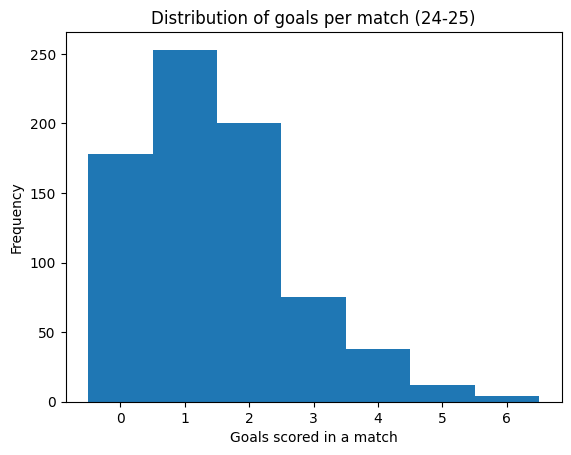

In [71]:
goals = pd.concat([
    train_df["HG"],
    train_df["AG"]
])

plt.figure()
plt.hist(goals, bins=range(0,8), align="left")
plt.xlabel("Goals scored in a match")
plt.ylabel("Frequency")
plt.title("Distribution of goals per match (24-25)")
plt.show()

**Comparison of true distribution and Poisson frit distribution**

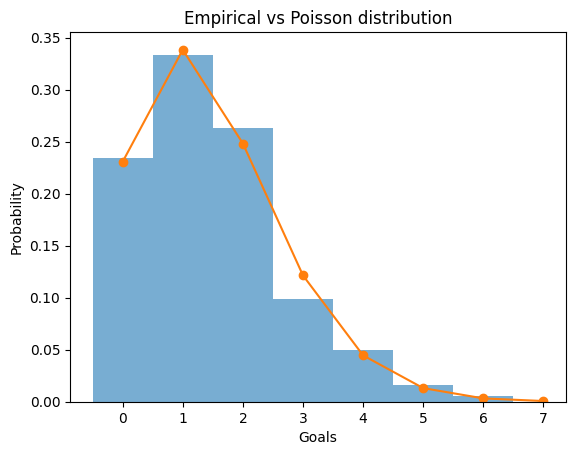

In [72]:
from scipy.stats import poisson
import numpy as np

mean_goals = goals.mean()
x = np.arange(0,8)
pmf = poisson.pmf(x, mean_goals)

plt.figure()
plt.hist(goals, bins=range(0,8), density=True, align="left", alpha=0.6)
plt.plot(x, pmf, marker="o")
plt.xlabel("Goals")
plt.ylabel("Probability")
plt.title("Empirical vs Poisson distribution")
plt.show()

**Heatmap**

In [73]:
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [74]:
row = pred_df[
    (pred_df["HomeTeam"] == "Manchester United") &
    (pred_df["AwayTeam"] == "Arsenal")
].iloc[0]

home = row["HomeTeam"]
away = row["AwayTeam"]
lambda_home_example = row["lambda_home"]
lambda_away_example = row["lambda_away"]

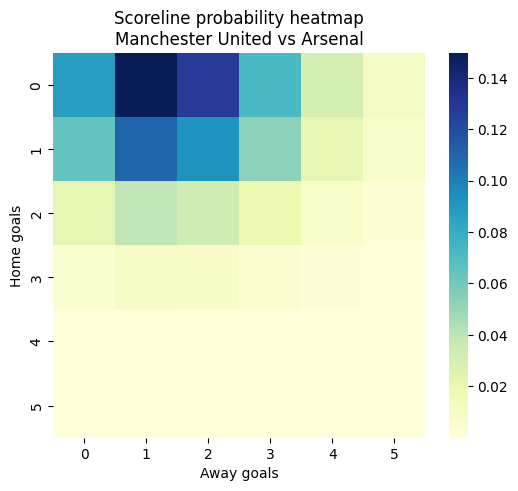

In [75]:
max_goals = 6
home_goals = np.arange(0, max_goals)
away_goals = np.arange(0, max_goals)

prob_matrix = np.outer(
    poisson.pmf(home_goals, lambda_home_example),
    poisson.pmf(away_goals, lambda_away_example)
)

plt.figure(figsize=(6,5))
sns.heatmap(
    prob_matrix,
    xticklabels=away_goals,
    yticklabels=home_goals,
    cmap="YlGnBu"
)
plt.xlabel("Away goals")
plt.ylabel("Home goals")
plt.title(f"Scoreline probability heatmap\n{home} vs {away}")
plt.show()

**Hit@K (Top-5 accuracy)**

1.   Mô hình được đánh giá bằng chỉ số Hit@K để cho thấy phân phối xác suất cho nhiều tỉ số khác nhau.

*   Hit@1: Tỉ số thực tế trùng với tỉ số có xác suất cao nhất.
*   Hit@3: tỉ số thực tế nằm trong 3 tỉ số có xác suất cao nhất.
*   Hit@5: tỉ số thực tế nằm trong 5 tỉ số có xác suất cao nhất.

2.   Việc sử dụng nhiều giá trị K giúp đánh giá chất lượng xếp hạng xác suất của mô hình, đặc biệt phù hợp với bài toán dự đoán tỉ số bóng đá vốn có mức độ bất định cao.

In [76]:
from scipy.stats import poisson
import numpy as np

In [77]:
def compute_true_rank(row, max_goals=6):
    lambda_h = row["lambda_home"]
    lambda_a = row["lambda_away"]

    true_score = (row["HG"], row["AG"])

    home_goals = np.arange(0, max_goals)
    away_goals = np.arange(0, max_goals)

    probs = []
    for h in home_goals:
        for a in away_goals:
            p = poisson.pmf(h, lambda_h) * poisson.pmf(a, lambda_a)
            probs.append(((h, a), p))

    probs.sort(key=lambda x: x[1], reverse=True)

    for rank, (score, _) in enumerate(probs, start=1):
        if score == true_score:
            return rank

    return np.nan

In [78]:
eval_df = eval_df.copy()
eval_df["TrueRank"] = eval_df.apply(compute_true_rank, axis=1)

In [79]:
hit1 = (eval_df["TrueRank"] == 1).mean()
hit3 = (eval_df["TrueRank"] <= 3).mean()
hit5 = (eval_df["TrueRank"] <= 5).mean()

hit1, hit3, hit5

(np.float64(0.12631578947368421),
 np.float64(0.32105263157894737),
 np.float64(0.46842105263157896))

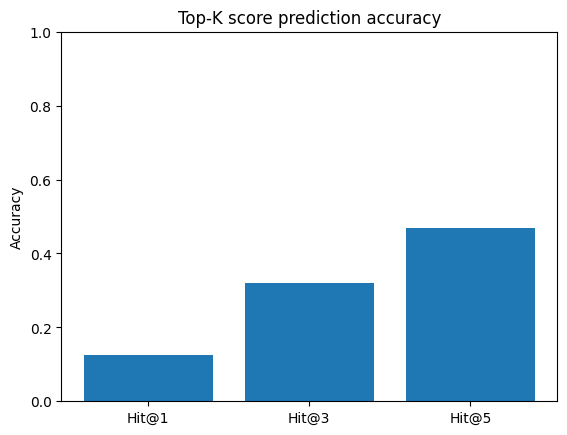

In [80]:
hits = {
    "Hit@1": hit1,
    "Hit@3": hit3,
    "Hit@5": hit5
}

plt.figure()
plt.bar(hits.keys(), hits.values())
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Top-K score prediction accuracy")
plt.show()

In [81]:
print(f"Hit@1: {hit1*100:.1f}%")
print(f"Hit@3: {hit3*100:.1f}%")
print(f"Hit@5: {hit5*100:.1f}%")

Hit@1: 12.6%
Hit@3: 32.1%
Hit@5: 46.8%


**Confusion Matrix**


1.   Confusion Matrix được sử dụng để đánh giá chất lượng dự đoán kết quả trận đấu(Home Win / Draw / Away Win) của mô hình.
2.   Ma trận này so sánh:

*   ActualResult: kết quả thực tế của trận đấu.
*   PredictedResult: kết quả có xác suất cao nhất do mô hình dự đoán.


3.   Confusion Matrix cho phép quan sát chi tiết các dạng dự đoán đúng và sai, đặc biệt giúp phát hiện các thiên lệch của mô hình.

*   Ví dụ như xu hướng dự đoán kém các trận hòa —> một hạn chế phổ biến của các mô hình Poisson độc lập.

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

eval_df = pred_df.copy()

def get_result(row):
    if row["HG"] > row["AG"]:
        return "H"
    elif row["HG"] == row["AG"]:
        return "D"
    else:
        return "A"

eval_df["ActualResult"] = eval_df.apply(get_result, axis=1)

eval_df["PredictedResult"] = eval_df["OutcomeProbs"].apply(
    lambda d: max(d, key=d.get)
)

In [83]:
labels = ["H", "D", "A"]

cm_model = confusion_matrix(
    eval_df["ActualResult"],
    eval_df["PredictedResult"],
    labels=labels
)


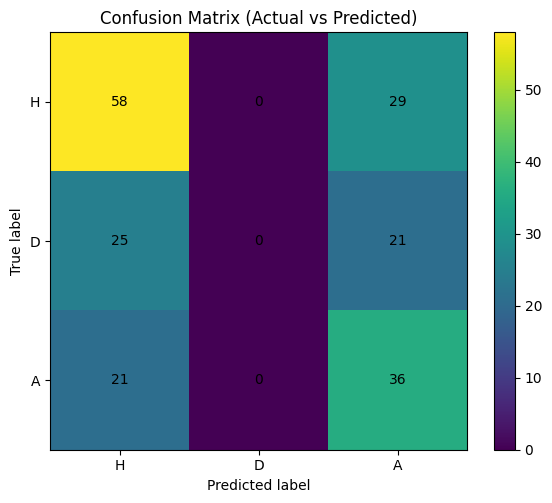

In [84]:
plt.figure(figsize=(6,5))
plt.imshow(cm_model)
plt.title("Confusion Matrix (Actual vs Predicted)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm_model[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


**Baseline Comparison**

**Always Home Win**


1.   Baseline “Always Home Win” giả định rằng "đội chủ nhà luôn thắng" trong mọi trận đấu.

2.   Baseline này được dùng để kiểm tra xem mô hình Poisson có thực sự học được cấu trúc dữ liệu hay chỉ dựa vào xu hướng chung của giải đấu.

In [85]:
eval_df["BaselinePred"] = "H"

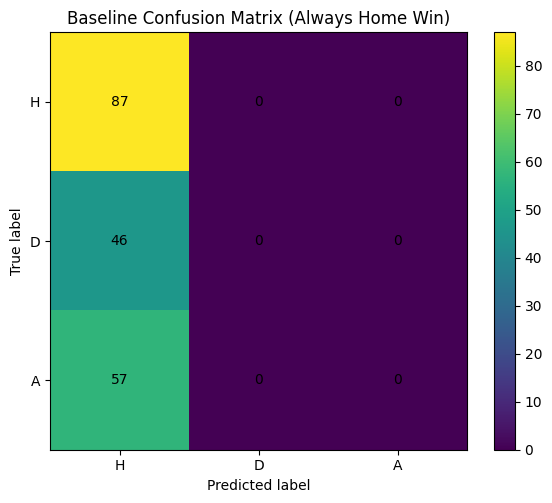

In [86]:
cm_baseline = confusion_matrix(
    eval_df["ActualResult"],
    eval_df["BaselinePred"],
    labels=labels
)
plt.figure(figsize=(6,5))
plt.imshow(cm_baseline)
plt.title("Baseline Confusion Matrix (Always Home Win)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(3), labels)
plt.yticks(range(3), labels)

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm_baseline[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

**Most Frequent Outcome**


1.   Baseline "Most Frequent Outcome" luôn dự đoán "kết quả xuất hiện nhiều nhất trong dữ liệu huấn luyện".

2.   So sánh mô hình Poisson với baseline này giúp đánh giá liệu mô hình có khả năng khái quát hóa tốt hơn so với việc chỉ dựa vào tần suất kết quả hay không.

In [87]:
most_freq = train_df.apply(get_result, axis=1).value_counts().idxmax()

print("Most frequent outcome (train):", most_freq)

eval_df["Baseline_MostFreq"] = most_freq

Most frequent outcome (train): H


In [88]:
cm_mf = confusion_matrix(
    eval_df["ActualResult"],
    eval_df["Baseline_MostFreq"],
    labels=["H", "D", "A"]
)

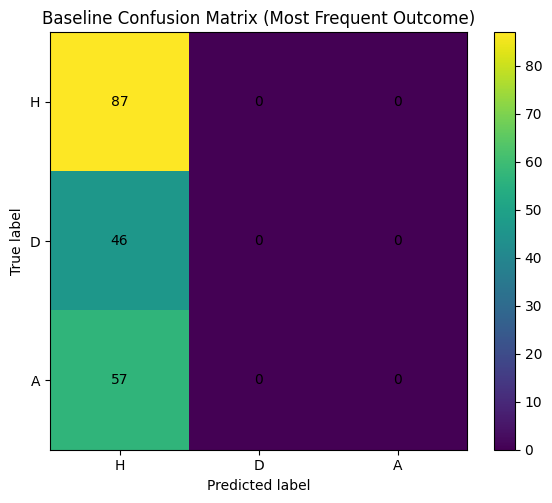

In [90]:
plt.figure(figsize=(6,5))
plt.imshow(cm_mf)
plt.title("Baseline Confusion Matrix (Most Frequent Outcome)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(range(3), ["H","D","A"])
plt.yticks(range(3), ["H","D","A"])

for i in range(3):
    for j in range(3):
        plt.text(j, i, cm_mf[i, j],
                 ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()